<a href="https://colab.research.google.com/github/panthrrr/ai-in-healthcare/blob/main/1_Classification_of_spoken_digits_with_snnTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of spoken digits with snnTorch

Developed by [Fredrik Sandin](https://www.ltu.se/staff/f/fresan-1.10646?l=en).

In this exercise you will learn how to load and transform an event dataset of speech and develop a spiking neural network for classification of spoken digits using snnTorch. See the related tutorials and lecture material referenced in Canvas for background information.

There are 3 ***mandatory tasks*** and 1 *optional task* in this exercise.

## 1 Import libraries
Unless you have already done so, you must first install snnTorch, Tonic, and matplotlib to run this exercise.

In [ ]:
!pip install snntorch
!pip install tonic
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 9.5 MB/s eta 0:00:00
  Created wheel for expelliarmus: filename=expelliarmus-1.1.12-cp312-cp312-linux_x86_64.whl size=56412 sha256=3fae30e709ed2304b404c033e99144c829ca5cbb324e0359f07074b8150d2588
  Stored in directory: /root/.cache/pip/wheels/9a/9e/4b/f96da4dab397e63f90078766122e078e4ba82b2b48e07ee644
Successfully built expelliarmus
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are in

^C


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import snntorch as snn

import tonic
from tonic import DiskCachedDataset
import tonic.transforms as transforms

import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics import confusion_matrix
from snntorch import surrogate
import snntorch.functional as SF


%matplotlib inline

## 2 Loading event data with Tonic

In this exercise you will load an event-based dataset using [Tonic](https://github.com/neuromorphs/tonic), which provides some publicly available event-based vision and audio datasets and event transformations. The package is compatible with snnTorch/PyTorch.

This exercise focuses on classifying spoken digits in the [Spiking Heidelberg Digits (SHD)](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/) dataset, which includes approximately 10000 high-quality aligned studio recordings of spoken digits from 0 to 9 in both German and English language from 12 distinct speakers, out of which two speakers are only present in the test set. Each digit is represented by spikes on 700 channels which were generated using [Lauscher](https://github.com/electronicvisions/lauscher), a neuromorphic [cochlea](https://iopscience.iop.org/article/10.1088/2634-4386/ac4a83#nceac4a83s47) software model. The SHD webpage referenced above includes a leader board and the data set is presented in the following paper.

Cramer, B., Stradmann, Y., Schemmel, J., and Zenke, F. (2022).
*The Heidelberg Spiking Data Sets for the Systematic Evaluation of Spiking Neural Networks*.
IEEE Transactions on Neural Networks and Learning Systems 33, 2744–2757.
[https://doi.org/10.1109/TNNLS.2020.3044364](https://doi.org/10.1109/TNNLS.2020.3044364).

Recent work by Boeshertz et al. (https://arxiv.org/abs/2407.13534) has show that it can be preferable to use adaptive LIF neurons to generate spikes from the original Heidelberg Digits data, both w.r.t. precision and data reduciton. For those of you who want to are ambiitons and want to expand your knowledge beyond the course content, read this paper, evaluate the proposed neuron model and hypothesize why it generates better spiking data than the alternative we load in this exercise.

### 2.1 Load the training dataset and plot samples
The SHD training set includes 8156 spoken digit samples. Each digit is represented by an array of events which consists of three parameters (timestamp t, cochlea channel number x, polarity p). Plot the spike representations of five different samples of one particular digit. What are the different channels representing? What is the time duration of the patterns? Why are the patterns different although the same digit is spoken?

***Mandatory task 1:***

Extend the code below so that it plots one digit sample for each of the 20 classes in the dataset. Thus, the subplot should have 20 panels. Each panel should illustrate one sample of one particular digit. Plot different samples and analyse the variations. Are different samples of one and the same digit similar or different? Why?

In [2]:
dataset = tonic.datasets.SHD(save_to='./shd', train=True)
sensor_size = dataset.sensor_size
print("Sensor size (# channels):", sensor_size)
print("Number of training samples:", len(dataset))
print("Event representation: ", dataset.dtype)
print("Classes:", [c.decode('UTF-8') for c in dataset.classes])

  0%|          | 0/130863613 [00:00<?, ?it/s]

Extracting ./shd/SHD/shd_train.h5.zip to ./shd/SHD
Sensor size (# channels): (700, 1, 1)
Number of training samples: 8156
Event representation:  [('t', '<i8'), ('x', '<i8'), ('p', '<i8')]
Classes: ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'null', 'eins', 'zwei', 'drei', 'vier', 'fuenf', 'sechs', 'sieben', 'acht', 'neun']


Collected 20 class samples


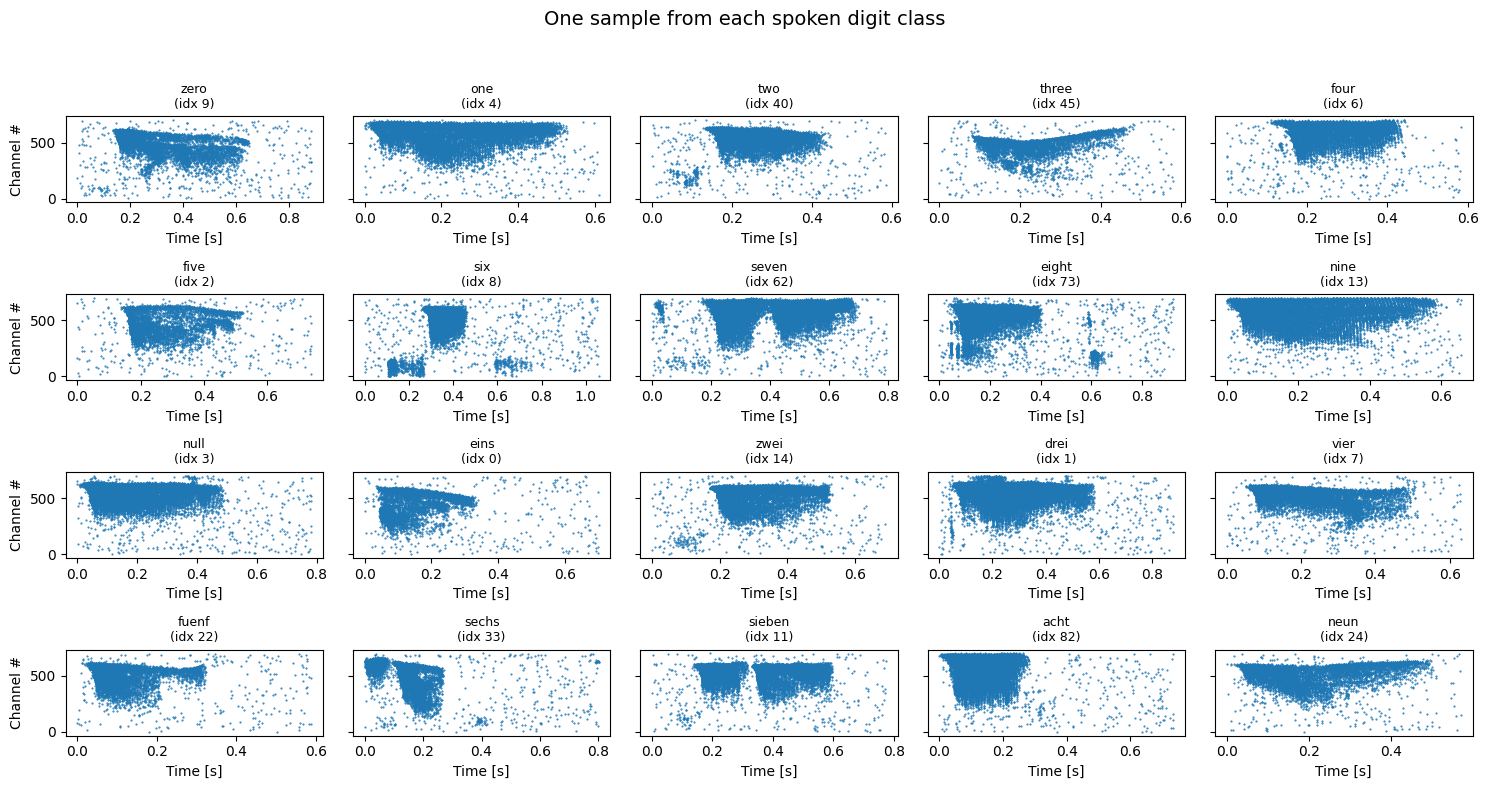

Digit 33 is represented by 5568 events
Digit 35 is represented by 8034 events
Digit 109 is represented by 5620 events
Digit 136 is represented by 5243 events
Digit 147 is represented by 6263 events


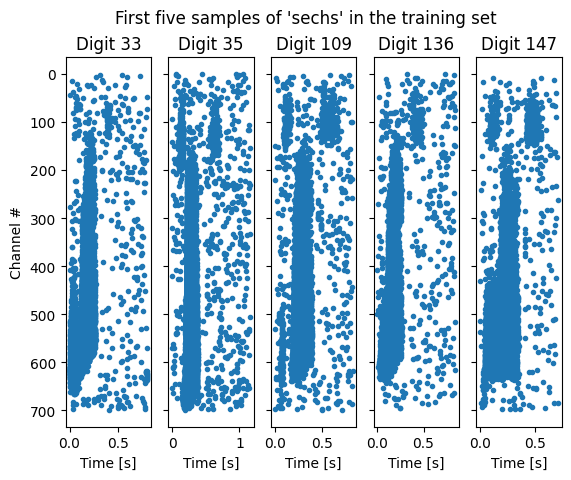

In [3]:
#NEW CODE START
samples_for_plotting = {} # Dictionary with key-value pairs
classes = [c.decode('UTF-8') for c in dataset.classes]
n_classes = len(classes)

i = 0
while len(samples_for_plotting) < n_classes and i < len(dataset):
  event, label = dataset[i]
  class_name = classes[label]
  if class_name not in samples_for_plotting:
    samples_for_plotting[class_name] = (event, i)
  i += 1
print(f"Collected {len(samples_for_plotting)} class samples") # Check so 20 samples have been collected

ncols = 5
nrows = 4

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8), sharey=True)
fig.suptitle("One sample from each spoken digit class", fontsize=14)
axs = axs.flatten()


for class_id, class_name in enumerate(classes):
    events, sample_index = samples_for_plotting[class_name]

    ax = axs[class_id]
    ax.set_visible(True)
    ax.scatter(1e-6 * events['t'], events['x'], marker=".", s=1)
    ax.invert_yaxis()
    ax.set_title(f"{class_name}\n(idx {sample_index})", fontsize=9)
    ax.set_xlabel("Time [s]")
    if class_id % ncols == 0: # Put the channel label on every 5 plots
        ax.set_ylabel("Channel #")



plt.tight_layout(rect=[0, 0, 1, 0.95]) # fix spacing so nothing overlaps
plt.show()
#NEW CODE END

samples = 0
index = 0
digit = "sechs"
fig, axs = plt.subplots(1,5, sharey=True)
fig.suptitle(f"First five samples of '{digit}' in the training set")
axs[0].set_ylabel("Channel #")
while samples < len(axs):
    events, label = dataset[index]
    if dataset.classes[label].decode('UTF-8') == digit:
        axs[samples].scatter(1e-6*events['t'], events['x'], marker=".")
        axs[samples].invert_yaxis()
        axs[samples].set_title(f"Digit {index}")
        axs[samples].set_xlabel("Time [s]")
        print(f"Digit {index} is represented by {len(events)} events")
        samples += 1
    index += 1

In [ ]:
# Tonic provides an event plotting function that can also be used (Time in ms), which rasterizes the events and displays the result with imshow().
tonic.utils.plot_event_grid(events)

### 2.2 Downsample the digits and create a dataloader

Now you are familiar with the samples in the dataset. It is time to prepare the digits in a format that is suitable for snnTorch experiments on a PC. To obtain state-of-the-art results we would need to keep a high spatial and temporal resolution of the digits. However, with 700 input channels the simulations would take far too long time if we process the full-resolution digits.

We can choose a set of transforms to apply to our data before feeding it to an SNN. Here we [Downsample](https://tonic.readthedocs.io/en/main/autoapi/tonic/transforms/index.html#tonic.transforms.Downsample) the events to 70 channels instead of 700, which reduces the dimension of the resulting tensor representations. Furthermore, we use the [toFrame](https://tonic.readthedocs.io/en/main/generated/tonic.transforms.ToFrame.html#tonic.transforms.ToFrame) transformation with time-binning over 10000 microseconds, which results in a sequence of 10-millisecond long frames with 70 channels each.

To speed up dataloading, we can make use of disk caching and batching. That means that once the files are loaded from the original dataset they are written to the disk. Because the event arrays have different lengths, we are going to use a collation function tonic.collation.PadTensors() that will pad shorter recordings to ensure all tensors in a batch have the same dimensions.

If you need to refresh basic machine learning concepts such as "batch" and "training set" a good reference is the [Deep Learning](https://www.deeplearningbook.org/) book, which is part of the course literature in the [D7046E Neural networks and learning machines](https://www.ltu.se/edu/course/D70/D7046E/D7046E-Neuronnat-och-larande-maskiner-1.183276?kursView=kursplan&l=en) course.

In [4]:
batch_size = 16 # Keeping this small for clarity of the examples below, you may need to increase it later

# OBS: You must first delete the cache files before running this with new parameters/transforms, otherwise there is no effect of modified hyperparameters

trainset = tonic.datasets.SHD(
    save_to='./data',
    train=True,
    transform=transforms.Compose([
        transforms.Downsample(sensor_size=sensor_size, spatial_factor=0.1), # 70 channels
        transforms.ToFrame(sensor_size=(70,1,1),time_window=10000) # us to 10 ms
    ])
)

cached_trainset = DiskCachedDataset(
    trainset,
    cache_path='./data/cache/shd/train',
    transform=torch.from_numpy
)

trainloader = DataLoader(
    cached_trainset,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors()
)

trainiter = iter(trainloader)

# Function that returns the next batch from the training set
def load_training_batch():
    events, targets = next(trainiter)
    # snnTorch torch uses time-first tensors, which means [time x batch_size x feature_dimensions].
    # Convert from the default [batch_size x time x 1 x channels] frame representation in the dataset:
    events = events.transpose(0,1).squeeze()
    return (events, targets)

  0%|          | 0/130863613 [00:00<?, ?it/s]

Extracting ./data/SHD/shd_train.h5.zip to ./data/SHD


### 2.3 Load one batch and visualize the downsampled digits

Shape of batch with 16 digits:  torch.Size([105, 16, 70])


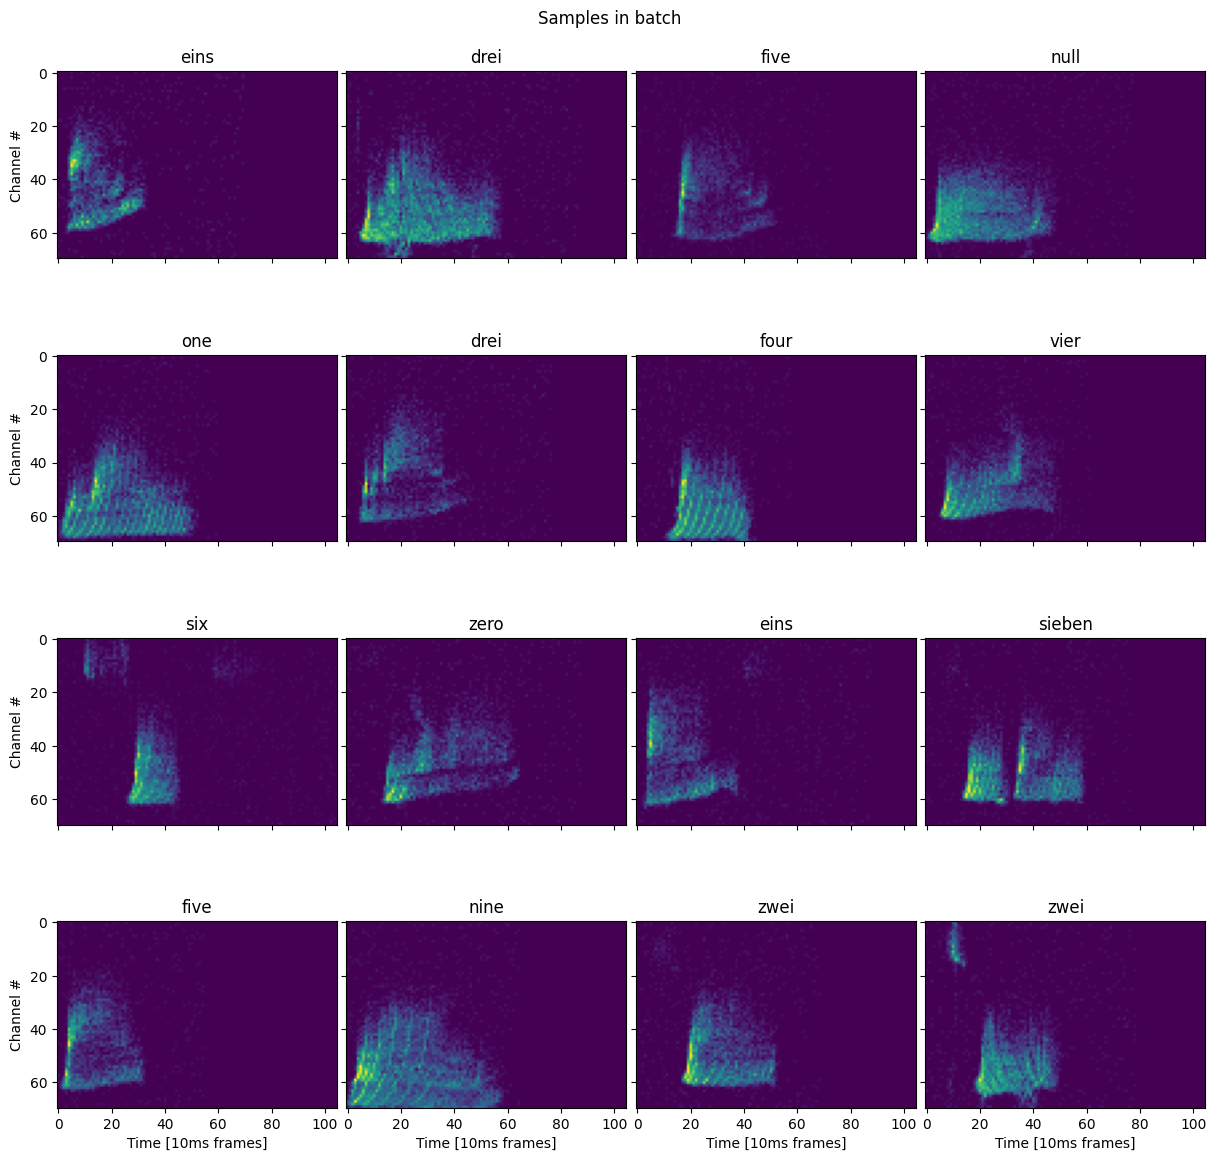

In [5]:
# Enable plotting of tensors with matplotlib
torch.Tensor.ndim = property(lambda self: len(self.shape))

events, target = load_training_batch()
print(f"Shape of batch with {batch_size} digits: ", events.shape)

fig,axs = plt.subplots(4,4,figsize=(12,12),sharex=True, sharey=True)
fig.suptitle(f"Samples in batch")

for i in range(4):
    axs[i,0].set_ylabel('Channel #')
    for j in range(4):
        index = i*4+j
        tensor = events[:,index,:].transpose(0,1)
        axs[i,j].imshow(tensor)
        axs[i,j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i==3:
            axs[i,j].set_xlabel('Time [10ms frames]')
plt.tight_layout(pad=0)
plt.show()

## 3 Processing of digits with a feed-forward SNN

The following is an adaptation of the feed-forward SNN example presented in the snnTorch [tutorial 3](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_3.html). The following code implements a feed-forward SNN that processes the downsampled digits in the SHD trainset visualized above. The code illustrates the principle of how to
   * Run a basic SNN simulation with SHD input data
   * Visualize the resulting spikes in the hidden and output layer

### 3.1 Run SNN simulation over timesteps in the batch

***Mandatory task 2:*** How much longer is the simulation time of one forward pass if the original number of channels (700) in the dataset is used? Does the time-binning introduced by the toFrame transformation reduce simulation time? Run simulations to validate your analysis.

In [6]:
num_timesteps = events.shape[0]     # Number of timesteps in the longest-duration digit
num_samples = events.shape[1]       # Number of digits in batch
num_channels = events.shape[2]      # Number of channels in downsampled digits
num_classes = len(trainset.classes)

# SNN hyperparameters
beta = 0.95
num_inputs = num_channels
num_outputs = num_classes
hidden_sizefac = 2        # Size of hidden layer in relation to size of input layer

# Define first hidden layer and input connections
fc1 = nn.Linear(num_inputs, hidden_sizefac*num_channels)
lif1 = snn.Leaky(beta=beta)

# Define output layer with inputs from hidden layer
fc2 = nn.Linear(hidden_sizefac*num_channels, num_outputs)
lif2 = snn.Leaky(beta=beta)

# Initialize neuron states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# Placeholders for outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

# Run network simulation over all timesteps in the input tensor
for step in range(num_timesteps):

    cur1 = fc1(events[step,:,:])  # post-synaptic current to hidden <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem1[t+1] <--post-syn current contrib + decayed membrane
    cur2 = fc2(spk1)              # post-synaptic current to output neurons
    spk2, mem2 = lif2(cur2, mem2) # output

    # Store states for analysis and plotting
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)
    mem2_rec.append(mem2)

# Convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

print("Hidden spikes shape", spk1_rec.shape)
print("Output spikes shape", spk2_rec.shape)
print("Output potential shape:", mem2_rec.shape)

Hidden spikes shape torch.Size([105, 16, 140])
Output spikes shape torch.Size([105, 16, 20])
Output potential shape: torch.Size([105, 16, 20])


In [7]:
#NEW CODE START
import time
import torch
import torch.nn as nn
import snntorch as snn
events_ds = events

def run_forward(events, num_channels, num_classes, hidden_sizefac=2, beta=0.95):
    num_timesteps = events.shape[0]     # Number of timesteps in the longest-duration digit
    num_samples = events.shape[1]       # Number of digits in batch


    # SNN hyperparameters
    num_inputs = num_channels
    num_outputs = num_classes

    # Define first hidden layer and input connections
    fc1 = nn.Linear(num_inputs, hidden_sizefac*num_channels)
    lif1 = snn.Leaky(beta=beta)

    # Define output layer with inputs from hidden layer
    fc2 = nn.Linear(hidden_sizefac*num_channels, num_outputs)
    lif2 = snn.Leaky(beta=beta)

    # Initialize neuron states
    mem1 = lif1.init_leaky()
    mem2 = lif2.init_leaky()

    # Placeholders for outputs
    mem2_rec = []
    spk1_rec = []
    spk2_rec = []

    # Run network simulation over all timesteps in the input tensor
    for step in range(num_timesteps):

        cur1 = fc1(events[step,:,:])  # post-synaptic current to hidden <-- spk_in x weight
        spk1, mem1 = lif1(cur1, mem1) # mem1[t+1] <--post-syn current contrib + decayed membrane
        cur2 = fc2(spk1)              # post-synaptic current to output neurons
        spk2, mem2 = lif2(cur2, mem2) # output

        # Store states for analysis and plotting
        spk1_rec.append(spk1)
        spk2_rec.append(spk2)
        mem2_rec.append(mem2)

    # Convert lists to tensors
    mem2_rec = torch.stack(mem2_rec)
    spk1_rec = torch.stack(spk1_rec)
    spk2_rec = torch.stack(spk2_rec)

    return mem2_rec, spk1_rec, spk2_rec


# run the forward pass with downsampled/full 700 channel version of data

num_classes = len(trainset.classes)

# Downsampled version
start = time.perf_counter()
with torch.no_grad():
    run_forward(events_ds, num_channels=events_ds.shape[2], num_classes=num_classes)
elapsed_ds = time.perf_counter() - start
print(f"Downsampled: {elapsed_ds:.4f} s")

# Full 700-channel version
# FULL 700-CHANNEL DATASET (no Downsample)
trainset_full = tonic.datasets.SHD(
    save_to='./data',
    train=True,
    transform=transforms.Compose([
        transforms.ToFrame(sensor_size=(sensor_size[0],1,1), time_window=10000)
    ])
)

cached_trainset_full = DiskCachedDataset(
    trainset_full,
    cache_path='./data/cache/shd/train_full',  # different cache path
    transform=torch.from_numpy
)

trainloader_full = DataLoader(
    cached_trainset_full,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors()
)

trainiter_full = iter(trainloader_full)

def load_training_batch_full():
    events_full, targets_full = next(trainiter_full)
    events_full = events_full.transpose(0, 1).squeeze()  # [T, B, 700]
    return events_full, targets_full

events_full, target_full = load_training_batch_full()
print("Full batch shape:", events_full.shape)  # should be [T_full, 16, 700]

# Full 700-channel version
start = time.perf_counter()
with torch.no_grad():
    run_forward(events_full, num_channels=events_full.shape[2], num_classes=num_classes)
elapsed_full = time.perf_counter() - start
print(f"Full 700 ch: {elapsed_full:.4f} s")

print(f"Speed factor (full / downsampled): {elapsed_full / elapsed_ds:.2f}x")

# 10 ms frames (baseline)
trainset_10ms = tonic.datasets.SHD(
    save_to='./data',
    train=True,
    transform=transforms.Compose([
        transforms.Downsample(sensor_size=sensor_size[0], spatial_factor=0.1),  # 70 ch
        transforms.ToFrame(sensor_size=(70,1,1), time_window=10_000)
    ])
)

# 5 ms frames (more bins in time)
trainset_5ms = tonic.datasets.SHD(
    save_to='./data',
    train=True,
    transform=transforms.Compose([
        transforms.Downsample(sensor_size=sensor_size, spatial_factor=0.1),  # 70 ch
        transforms.ToFrame(sensor_size=(70,1,1), time_window=5_000)
    ])
)

# Cache + loaders for 10 ms
cached_trainset_10ms = DiskCachedDataset(
    trainset_10ms,
    cache_path='./data/cache/shd/train_10ms',
    transform=torch.from_numpy
)

trainloader_10ms = DataLoader(
    cached_trainset_10ms,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors()
)

# Cache + loaders for 5 ms
cached_trainset_5ms = DiskCachedDataset(
    trainset_5ms,
    cache_path='./data/cache/shd/train_5ms',
    transform=torch.from_numpy
)

trainloader_5ms = DataLoader(
    cached_trainset_5ms,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors()
)

print("--------------------")
# Get one batch from each
events_10ms, target_10ms = next(iter(trainloader_10ms))
events_10ms = events_10ms.transpose(0, 1).squeeze()  # [T_10, B, 70]

events_5ms, target_5ms = next(iter(trainloader_5ms))
events_5ms = events_5ms.transpose(0, 1).squeeze()    # [T_5, B, 70]

print("10 ms batch shape:", events_10ms.shape)
print(" 5 ms batch shape:", events_5ms.shape)

# Time forward passes
start = time.perf_counter()
with torch.no_grad():
    run_forward(events_10ms, num_channels=events_10ms.shape[2], num_classes=num_classes)
t_10 = time.perf_counter() - start
print(f"10 ms frames time: {t_10:.4f} s")

start = time.perf_counter()
with torch.no_grad():
    run_forward(events_5ms, num_channels=events_5ms.shape[2], num_classes=num_classes)
t_5 = time.perf_counter() - start
print(f" 5 ms frames time: {t_5:.4f} s")

print(f"Time ratio (5 ms / 10 ms): {t_5 / t_10:.2f}x")

print("Time binning reduces simulation time because having fewer bins means that more spikes are being put into one bin, and there will be less simulations.")

#NEW CODE END

Downsampled: 0.0751 s
Full batch shape: torch.Size([105, 16, 700])
Full 700 ch: 0.2362 s
Speed factor (full / downsampled): 3.15x
--------------------
10 ms batch shape: torch.Size([105, 16, 70])
 5 ms batch shape: torch.Size([211, 16, 70])
10 ms frames time: 0.0907 s
 5 ms frames time: 0.1472 s
Time ratio (5 ms / 10 ms): 1.62x
Time binning reduces simulation time because having fewer bins means that more spikes are being put into one bin, and there will be less simulations.


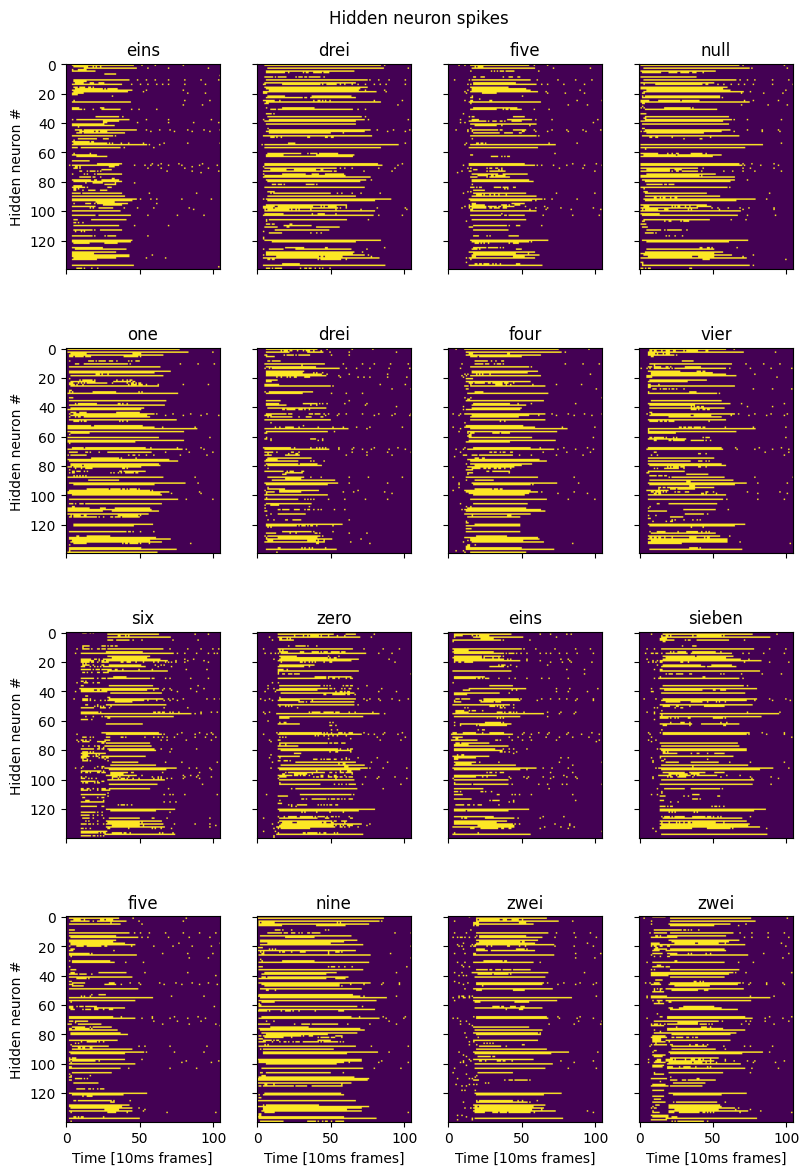

In [8]:
# Plot activity of hidden neurons for each input digit in the batch
s = spk1_rec.detach().numpy()
fig,axs = plt.subplots(4,4,figsize=(8,12),sharex=True,sharey=True)
fig.suptitle(f"Hidden neuron spikes")
fig.tight_layout()
for i in range(4):
    axs[i,0].set_ylabel('Hidden neuron #')
    for j in range(4):
        index = i*4+j
        tensor = s[:,index,:].squeeze().transpose(1,0)
        axs[i,j].imshow(tensor)
        axs[i,j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i==3:
            axs[i,j].set_xlabel('Time [10ms frames]')
plt.show()

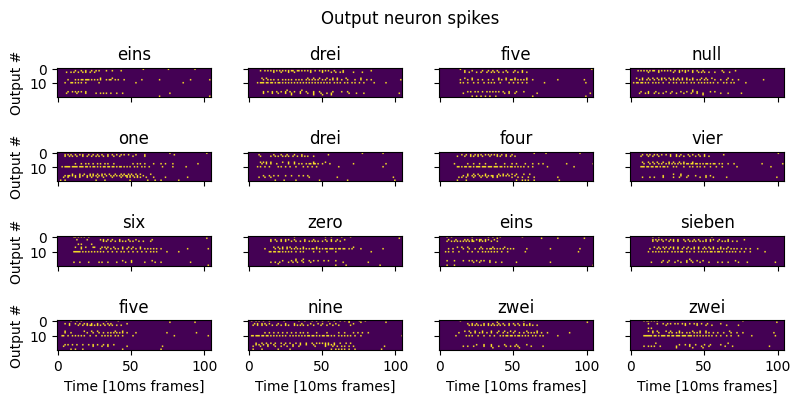

In [9]:
# Plot activity of output neurons for each input digit in the batch
s = spk2_rec.detach().numpy()
fig,axs = plt.subplots(4,4,figsize=(8,4),sharex=True,sharey=True)
fig.suptitle(f"Output neuron spikes")
fig.tight_layout()
for i in range(4):
    axs[i,0].set_ylabel('Output #')
    for j in range(4):
        index = i*4+j
        tensor = s[:,index,:].squeeze().transpose(1,0)
        axs[i,j].imshow(tensor)
        axs[i,j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i==3:
            axs[i,j].set_xlabel('Time [10ms frames]')
plt.show()

## 4 Train an SNN to classify the digits

***Mandatory task 3:***

Based on your understanding of the code above and the [snnTorch tutorial 5](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_5.html) (and any other documented functions in snnTorch) that you think are required, develop and train a feed-forward SNN for classification of the 20 different digits in the SHD dataset.

The goal is that after training the 20 output neurons of the networks should differentiate between the 20 different digits in the training set, in the sense that for each target/class one particular output neuron is more likely to fire and/or fires with a higher spikerate than the other 19 neurons.

Note that you cannot directly copy the example in tutorial 5 because the SHD digits have varying duration in time (while the MNIST samples in the tutorial have fixed dimensionality and consequently the inputs could be flattened to vectors in that case). Here you need to consider and optimize the response of the output neurons over time when each digit is presented to the network.

Plot the ***loss curve*** from the start until the end of training (over all "epochs"). The goal is that the loss should decrease and eventually converge or fluctuate at a low value. What is the ***accuracy of your classifier*** before and after training? Plot a ***confusion matrix***, what are the weaknesses/strengths of your classifier based on the result?

***Hints:***

Use the discussion forum for exercises in Canvas if you get stuck. Share what you have learned and what question you have.

Using device: cpu
SHDNet(
  (fc1): Linear(in_features=70, out_features=140, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=140, out_features=20, bias=True)
  (lif2): Leaky()
)


  0%|          | 0/38141465 [00:00<?, ?it/s]

Extracting ./data/SHD/shd_test.h5.zip to ./data/SHD
Train batch acc BEFORE training: 6.25%
Test  batch acc BEFORE training: 6.25%
Epoch 1/3: train loss=273.646, test loss=234.679
Epoch 2/3: train loss=233.427, test loss=234.516
Epoch 3/3: train loss=217.248, test loss=218.191


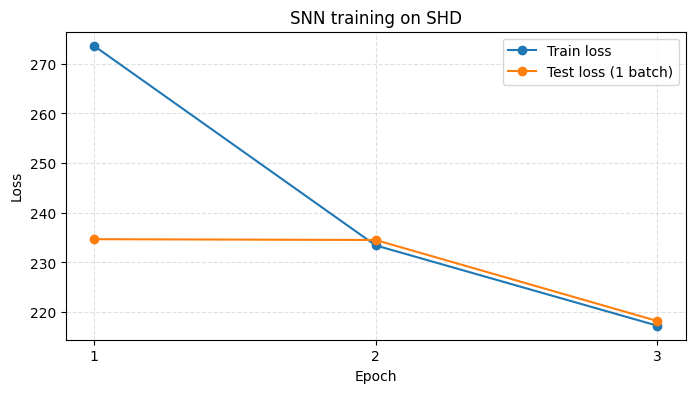

Train accuracy AFTER training: 49.40%
Test  accuracy AFTER training: 46.25%
Confusion matrix shape: (20, 20)


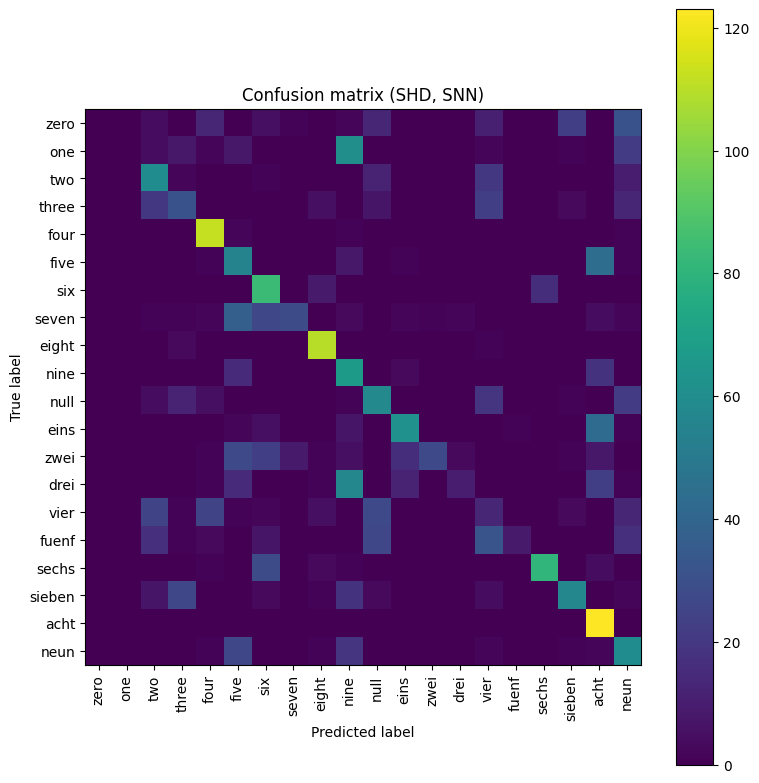

In [10]:
# Develop and train SNN classifier
# NEW CODE START

# Builds a feed-forward SNN and trains it to classify the 20 spoken digits in the dataset.


# -----------------------------
# Hyperparameters and settings
# -----------------------------

beta = 0.95 # membrane decay constant (leaky integrate-and-fire)
hidden_sizefac = 2
num_hidden = hidden_sizefac * num_channels # hidden layer size (num_channels from earlier code)

num_epochs = 3  # Number of training passes
                # 5 was slow, change to more epochs for higher accuracy

max_batches_per_epoch = 400 # LIMIT TRAINING BATCHES PER EPOCH for speed
                            # (None = use all) lower value => faster but less trained

# Use GPU if available in Colab, otherwise cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# -----------------------------
# SNN model definition
# -----------------------------

# inspired by the snnTorch tutorial 5 and the demo code in the notebook.
# Here we adapt it to temporal SHD data [T, B, C] instead of static MNIST images.


class SHDNet(nn.Module): # Class for our SHD network

# Input (C channels) -> Hidden LIF layer -> Output LIF layer (20 classes).
# Time: looping over T timesteps in forward().

    def __init__(self, num_inputs, num_hidden, num_outputs, beta=0.95):
        super().__init__()

        # Fully connected layer from input channels to hidden neurons
        self.fc1  = nn.Linear(num_inputs, num_hidden)

        # Leaky Integrate-and-Fire layer with surrogate gradient for backprop
        self.lif1 = snn.Leaky(beta=beta,
                              spike_grad=surrogate.fast_sigmoid(slope=25))# surrogate gradient

        # Fully connected layer from hidden to output neurons (one per class)
        self.fc2  = nn.Linear(num_hidden, num_outputs)

        # Second LIF layer at the output, also with surrogate gradient
        self.lif2 = snn.Leaky(beta=beta,
                              spike_grad=surrogate.fast_sigmoid(slope=25))# surrogate gradient

    def forward(self, x):

        """
        x: Input spike frames with shape [T, B, C]
           T = number of time steps (frames)
           B = batch size (number of digits in the batch)
           C = number of channels (70 after downsampling)
        Returns:
            spk2_rec: output spikes over time, shape [T, B, num_outputs]
            mem2_rec: output membrane potentials over time, same shape
        """

        T, B, _ = x.shape

        # Initialize membrane potentials for both LIF layers.
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Lists to record output spikes and membrane potentials at each time step
        spk2_rec = []
        mem2_rec = []

        # Loop over time
        for t in range(T):
            # x[t] has shape [B, C]. This is all the samples at time t

            cur1 = self.fc1(x[t])           # Linear current into hidden layer [B, num_hidden]
            spk1, mem1 = self.lif1(cur1, mem1) # Hidden spikes + updated membrane

            cur2 = self.fc2(spk1)           # Linear current into output layer [B, num_outputs]
            spk2, mem2 = self.lif2(cur2, mem2) # Output spikes + updated membrane

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        # Stack the lists into tensors with time as first dimension
        spk2_rec = torch.stack(spk2_rec, dim=0)   # [T, B, num_outputs]
        mem2_rec = torch.stack(mem2_rec, dim=0)   # [T, B, num_outputs]
        return spk2_rec, mem2_rec

# Instantiate the network with our chosen sizes and move it to CPU/GPU
net = SHDNet(num_inputs=num_channels,
             num_hidden=num_hidden,
             num_outputs=num_classes,
             beta=beta).to(device)
print(net)


# -----------------------------
# Loss function and optimizer
# -----------------------------

# as in Tutorial 5.

loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

def batch_accuracy(spk_rec, targets):
    # rate code: sum spikes over time to get a spike count per neuron
    spk_sum = spk_rec.sum(dim=0)         # [B, num_outputs]
    _, pred = spk_sum.max(1)             # index of neuron with most spikes
    correct = (pred == targets).float().mean().item()
    return correct


# -----------------------------
# Test set + loader
# -----------------------------

# Like previously in this notebook

testset = tonic.datasets.SHD(
    save_to='./data',
    train=False,
    transform=transforms.Compose([
        transforms.Downsample(sensor_size=sensor_size[0], spatial_factor=0.1),
        transforms.ToFrame(sensor_size=(70,1,1), time_window=10_000)
    ])
)

cached_testset = DiskCachedDataset(
    testset,
    cache_path='./data/cache/shd/test',
    transform=torch.from_numpy
)

testloader = DataLoader(
    cached_testset,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors()
)

# -----------------------------
# Helper functions
# -----------------------------


# Convert a batch from the DataLoader into the format expected by the SNN.
# Input events: [B, T, 1, C]  (batch, time, dummy, channels)
# Output events: [T, B, C]
def prep_batch(batch):
    events, targets = batch               # events: [B, T, 1, C]
    events = events.transpose(0, 1).squeeze()  # [B, T, 1, C] -> [T, B, C]
    events = events.to(device).float() # move to cpu/gpu
    targets = targets.to(device).long()
    return events, targets

# Check accuracy on ONE batch from a loader
def eval_one_batch(loader, net):
    net.eval()
    with torch.no_grad():
        batch = next(iter(loader)) # Get one batch
        events, targets = prep_batch(batch) # Format batch to fit [T, B, C]
        spk_rec, mem_rec = net(events)
        acc = batch_accuracy(spk_rec, targets)
    return acc


# -----------------------------
# Accuracy BEFORE training
# -----------------------------

acc_train_before = eval_one_batch(trainloader, net)
acc_test_before  = eval_one_batch(testloader, net)

print(f"Train batch acc BEFORE training: {acc_train_before*100:.2f}%")
print(f"Test  batch acc BEFORE training: {acc_test_before*100:.2f}%")


# -----------------------------
# Training loop
# -----------------------------
# Loops over time since the inputs are sequences

train_loss_hist = [] # List to store average train loss per epoch
test_loss_hist  = [] # List to store test loss on a single batch per epoch

for epoch in range(num_epochs):
    net.train() # set SNN model to training mode
    running_loss = 0.0
    n_batches = 0

    # Iterate over batches from the training loader
    for n_batches, batch in enumerate(trainloader):

        # Limit the number of batches in each epoch, stop if our limit is reached
        if max_batches_per_epoch is not None and n_batches >= max_batches_per_epoch:
          break

        events, targets = prep_batch(batch) # Format batch to fit [T, B, C]

        # -------- Forward pass --------
        spk_rec, mem_rec = net(events)      # mem_rec: [T,B,num_classes]

        # -------- Loss computation --------
        # loss summed over all timesteps
        # Encourages the correct output neuron to be active during the whole duration of that input digit.
        loss_val = 0.0
        for t in range(mem_rec.size(0)):
            loss_val = loss_val + loss_fn(mem_rec[t], targets)

        # -------- Backward pass and update --------
        optimizer.zero_grad() # reset gradients
        loss_val.backward() # compute gradients (using surrogate spikes)
        optimizer.step() # update weights


        running_loss += loss_val.item()
        n_batches += 1

    # Average training loss over the batches we used
    avg_train_loss = running_loss / n_batches
    train_loss_hist.append(avg_train_loss)

'''
    # test loss on one batch for monitoring
    net.eval()
    with torch.no_grad():
        test_batch = next(iter(testloader))
        events_t, targets_t = prep_batch(test_batch)
        spk_rec_t, mem_rec_t = net(events_t)
        test_loss_val = 0.0
        for t in range(mem_rec_t.size(0)):
            test_loss_val = test_loss_val + loss_fn(mem_rec_t[t], targets_t)
        test_loss_hist.append(test_loss_val.item())

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"train loss={avg_train_loss:.3f}, test loss={test_loss_val.item():.3f}")
'''

# -----------------------------
# Plotting the loss function
# -----------------------------
# Shows how the loss changes over epochs.
# We expect it to go down and then level out.

plt.figure(figsize=(8,4))
epochs = np.arange(1, num_epochs + 1)
plt.plot(epochs, train_loss_hist, marker='o', label="Train loss")
plt.plot(epochs, test_loss_hist, marker='o', label="Test loss (1 batch)")
plt.xticks(epochs)  # force x axis marks to be 1, 2, 3, ... to count epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.title("SNN training on SHD")
plt.show()


# -----------------------------
# Accuracy AFTER training
# -----------------------------
# Evaluating the trained model on the full train and test sets.


def evaluate_loader(loader, net):
    net.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch in loader:
            events, targets = prep_batch(batch)
            spk_rec, mem_rec = net(events)
            spk_sum = spk_rec.sum(dim=0)      # [B, num_classes]
            _, pred = spk_sum.max(1)
            total += targets.size(0)
            correct += (pred == targets).sum().item()
    return correct / total

acc_train_after = evaluate_loader(trainloader, net)
acc_test_after  = evaluate_loader(testloader, net)

print(f"Train accuracy AFTER training: {acc_train_after*100:.2f}%")
print(f"Test  accuracy AFTER training: {acc_test_after*100:.2f}%")


# -----------------------------
# Confusion matrix on test set
# -----------------------------

all_targets = []
all_preds   = []

net.eval()
with torch.no_grad():
    for batch in testloader:
        events, targets = prep_batch(batch)
        spk_rec, mem_rec = net(events)
        spk_sum = spk_rec.sum(dim=0)      # [B, num_classes]
        _, pred = spk_sum.max(1)

        all_targets.append(targets.cpu().numpy())
        all_preds.append(pred.cpu().numpy())

# Concatenate predictions from all batches
all_targets = np.concatenate(all_targets)
all_preds   = np.concatenate(all_preds)

# Build confusion matrix: rows = true class, columns = predicted class
cm = confusion_matrix(all_targets, all_preds, labels=range(num_classes))
print("Confusion matrix shape:", cm.shape)

plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix (SHD, SNN)")
plt.colorbar()
tick_marks = np.arange(num_classes)
class_names = [c.decode('UTF-8') for c in trainset.classes]
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


# NEW CODE END

## 5 Test and improve the trained SNN

***Optional task:***

Test and improve the accuracy of your SNN classifier. How high accuracy can you achieve? How close to the SHD leader board is your result? Can you benefit from spiking CNNs, LSTMSs, ...?


In [ ]:
testset = tonic.datasets.SHD(save_to='./data', train=False)

cached_testset = DiskCachedDataset(testset, transform=...

testloader = DataLoader(cached_testset, ...

## References

The Heidelberg Spiking Data Sets for the Systematic Evaluation of Spiking Neural Networks;
[https://doi.org/10.1109/TNNLS.2020.3044364](https://doi.org/10.1109/TNNLS.2020.3044364).

Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-Based Optimization to Spiking Neural Networks; [https://doi.org/10.1109/MSP.2019.2931595](https://doi.org/10.1109/MSP.2019.2931595).

Training Spiking Neural Networks Using Lessons From Deep Learning; [https://doi.org/10.1109/JPROC.2023.3308088](https://doi.org/10.1109/JPROC.2023.3308088).